In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
netflix = pd.read_csv('/Users/yenhann/Documents/MIT/15.572 Analytics Lab/Datasets/complete_manually_cleaned_data.csv')
ratings = pd.read_csv('/Users/yenhann/Documents/MIT/15.572 Analytics Lab/Datasets/title.ratings.tsv', sep='\t')

df = netflix.merge(ratings, how='left', on='tconst')

#My Wonderful Life Manually added data

df.loc[df['title']=='my wonderful life', 'averageRating'] = 5.9
df.loc[df['title']=='my wonderful life', 'numVotes'] = 714
df.loc[df['title']=='my wonderful life', 'titleType'] = 'movie'
df.loc[df['title']=='my wonderful life', 'runtimeMinutes'] = 99
df.loc[df['title']=='my wonderful life', 'isAdult'] = 0
df.loc[df['title']=='my wonderful life', 'genres'] = 'Comedy,Drama,Romance'

In [3]:
df['is_top10'] = df['is_top10'].astype(int)
df.replace('\\N', np.nan, inplace=True)

In [4]:
movies, tv_shows = df[df['is_tv_show']==False], df[df['is_tv_show']==True]

In [39]:
df = pd.read_csv('/Users/yenhann/Documents/MIT/15.572 Analytics Lab/Datasets/feed_into_pipeline_data_withTags.csv')

# #My Wonderful Life Manually added data

df.loc[df['lower_title']=='my wonderful life', 'averageRating'] = 5.9
df.loc[df['lower_title']=='my wonderful life', 'numVotes'] = 714
df.loc[df['lower_title']=='my wonderful life', 'titleType'] = 'movie'
df.loc[df['lower_title']=='my wonderful life', 'runtimeMinutes'] = 99
df.loc[df['lower_title']=='my wonderful life', 'isAdult'] = 0
df.loc[df['lower_title']=='my wonderful life', 'genres'] = 'Comedy,Drama,Romance'

In [40]:
movies, tv_shows = df[df['is_tv_show']==False], df[df['is_tv_show']==True]

# Movies

## Data Preparation

In [6]:
# drop columns that are not needed
movies = movies.drop(['tconst', 'release_date','combined_title', 'title', 'season', 'is_tv_show', 'isAdult'], axis = 1)

In [7]:
movies.columns
movies

,release_year,is_top10,averageRating_x,numVotes_x,titleType,runtimeMinutes,genres,averageRating_y,numVotes_y,averageRating,numVotes
2,2020,0,6.1,856.0,movie,100,"Comedy,Family",6.1,856.0,NaN,NaN
4,2021,1,5.8,1531.0,movie,102,"Comedy,Romance",5.8,1531.0,NaN,NaN
5,2022,1,6.9,1928.0,movie,92,Documentary,6.9,1928.0,NaN,NaN
7,2021,1,6.3,932.0,movie,104,"Crime,Documentary",6.3,932.0,NaN,NaN
8,2022,0,5.2,621.0,movie,91,"Comedy,Drama,Family",5.2,621.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2216,2022,0,6.5,46.0,tvSpecial,59,"Comedy,Documentary",6.5,46.0,NaN,NaN
2218,2021,1,6.7,925.0,movie,102,"Biography,Drama,Sport",6.7,925.0,NaN,NaN
2220,2020,0,6.3,2648.0,movie,97,"Documentary,Music",6.3,2648.0,NaN,NaN
2223,2021,1,7.5,103877.0,movie,120,"Biography,Drama,Musical",7.5,103877.0,NaN,NaN


In [8]:
movies = movies[['release_year','is_top10', 'averageRating_x', 'numVotes_x','titleType','runtimeMinutes','genres']]

In [9]:
movies = movies.rename(columns = {'averageRating_x': 'averageRating', 'numVotes_x': 'numVotes'})

In [10]:
movies = movies.reset_index(drop = True)

In [11]:
movies.isna().sum()

release_year      0
is_top10          0
averageRating     4
numVotes          4
titleType         0
runtimeMinutes    5
genres            0
dtype: int64

In [12]:
movies.titleType.value_counts()

movie        742
tvSpecial    130
short         46
Name: titleType, dtype: int64

### Impute averageRating, numVotes, and runtimeMinutes with Mean

In [13]:
from sklearn.model_selection import train_test_split
movies_train, movies_test = train_test_split(movies, test_size=0.3, random_state=100)

# Training set
movies_train_X = movies_train.drop(['is_top10'], axis = 1)
movies_train_Y = movies_train['is_top10']

# Test set
movies_test_X = movies_test.drop(['is_top10'], axis = 1)
movies_test_Y = movies_test['is_top10']

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),                # One hot encode title types
    ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),   # Impute missing ratings, votes, and runtime with the average
    ("bagofw", CountVectorizer(), 'genres')                                                         # Splits genres into bag of words and encode them
    ],
    remainder='passthrough')

### Model 1 : Decision Tree

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
import sklearn.preprocessing
import sklearn.linear_model

# make sklearn pipeline with transform, normalization, and model (CART)
pipeTree = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        # ('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        # ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('decisiontree', sklearn.tree.DecisionTreeClassifier())                             # Build Decision Tree model
    ]
)    

In [18]:
# use grid search to cross validate tree model - 5-fold cross validation
from sklearn.model_selection import GridSearchCV

gsTree = GridSearchCV(
    pipeTree,
    param_grid={
        'decisiontree__max_depth': [5, 6, 7, 8, 9, 10],
        'decisiontree__min_samples_leaf': [1, 5, 10, 15, 20],
        'decisiontree__criterion': ['gini', 'entropy', 'log_loss'],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [45]:
gsTree.fit(movies_train_X, movies_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
            

In [46]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gsTree.best_params_
gsTree.best_score_
best_decisiontree = gsTree.best_estimator_

Accuracy:  0.7318840579710145
AUC:  0.7759191176470588


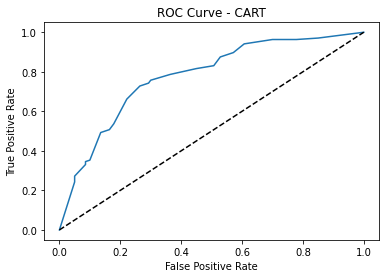

In [47]:
best_decisiontree.fit(movies_train_X, movies_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_decisiontree.predict_proba(movies_test_X)[:,1]
y_pred = best_decisiontree.predict(movies_test_X)

print("Accuracy: ", accuracy_score(movies_test_Y, y_pred))
print("AUC: ", roc_auc_score(movies_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(movies_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CART')
plt.show()

AUCPR:  0.7638057365680034


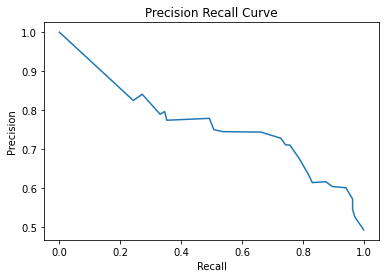

F1 Score:  0.7279411764705882


In [48]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(movies_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(movies_test_Y, y_pred))

### Model 2 : Random Forest

In [24]:
# make sklearn pipeline with transform, normalization, and model (RF)
from sklearn.ensemble import RandomForestClassifier

pipeRF = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        #('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        #('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('randomforest', sklearn.ensemble.RandomForestClassifier())                             # Build Decision Tree model
    ]
)    

In [25]:
gsRF = GridSearchCV(
    pipeRF,
    param_grid={
        'randomforest__n_estimators': [100, 250, 500],
        'randomforest__max_depth': [5, 10, 15, 20, 25, 30],
        'randomforest__min_samples_leaf': [1, 5, 10, 15, 20],
        'randomforest__criterion': ['gini', 'entropy', 'log_loss'],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [101]:
gsRF.fit(movies_train_X, movies_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
450 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
            

In [91]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gsRF.best_params_
gsRF.best_score_
best_randomforest = gsRF.best_estimator_

Accuracy:  0.7572463768115942
AUC:  0.8112394957983193


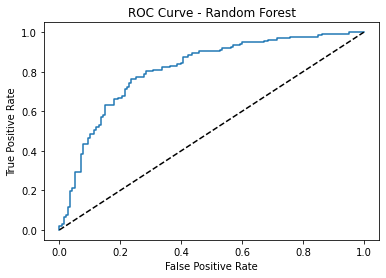

In [92]:
best_randomforest.fit(movies_train_X, movies_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_randomforest.predict_proba(movies_test_X)[:,1]
y_pred = best_randomforest.predict(movies_test_X)

print("Accuracy: ", accuracy_score(movies_test_Y, y_pred))
print("AUC: ", roc_auc_score(movies_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(movies_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.show()

AUCPR:  0.768029228782249


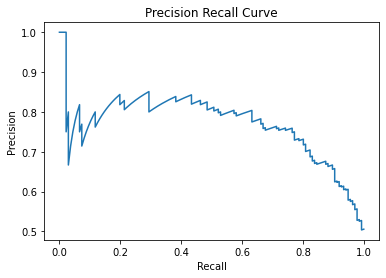

F1 Score:  0.7649122807017543


In [93]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(movies_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(movies_test_Y, y_pred))

### Model 3 : Feed Forward Neural Network

In [95]:
# make sklearn pipeline with transform, normalization, and model (RF)
from sklearn.neural_network import MLPClassifier

pipeMLP = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        ('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('neuralnetwork', sklearn.neural_network.MLPClassifier())                           # Build Neural Network
    ]
)    

In [112]:
gsMLP = GridSearchCV(
    pipeMLP,
    param_grid={
        'neuralnetwork__hidden_layer_sizes': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        'neuralnetwork__activation': ['relu','tanh','logistic'],
        'neuralnetwork__learning_rate': ['constant','adaptive'],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [114]:
gsMLP.fit(movies_train_X, movies_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yenhann/o

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
            

In [115]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gsMLP.best_params_
gsMLP.best_score_
best_neuralnet = gsMLP.best_estimator_

Accuracy:  0.6630434782608695
AUC:  0.7396533613445377


/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


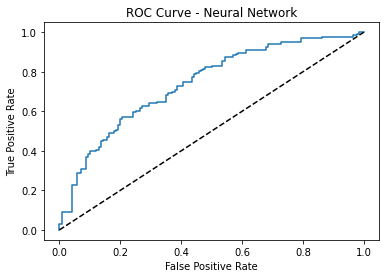

In [116]:
best_neuralnet.fit(movies_train_X, movies_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_neuralnet.predict_proba(movies_test_X)[:,1]
y_pred = best_neuralnet.predict(movies_test_X)

print("Accuracy: ", accuracy_score(movies_test_Y, y_pred))
print("AUC: ", roc_auc_score(movies_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(movies_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.show()

AUCPR:  0.7189326884273471


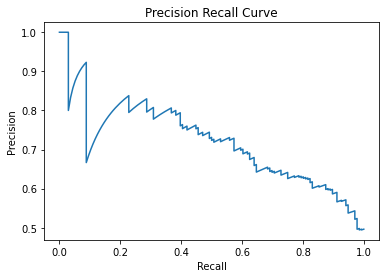

F1 Score:  0.6910299003322258


In [117]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(movies_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(movies_test_Y, y_pred))

## TV Shows

### Data Preparation

In [41]:
tv_shows

,combined_title,release_year,release_date,is_top10,lower_title,season,is_tv_show,tconst,averageRating,numVotes,...,release_date_quarter,release_date_month,release_date_week,nudity,violence,profanity,alcohol,frightening,language,isAdult
1,American Idol: Season 18,2020,2/13/20,0,american idol,18.0,True,tt0319931,4.2,21739,...,1,2,7,None,Mild,Mild,Mild,Moderate,English,NaN
2,American Idol: Season 19,2021,2/12/21,0,american idol,19.0,True,tt0319931,4.2,21739,...,1,2,6,None,Mild,Mild,Mild,Moderate,English,NaN
3,American Idol: Season 20,2022,2/27/22,0,american idol,20.0,True,tt0319931,4.2,21739,...,1,2,8,None,Mild,Mild,Mild,Moderate,English,NaN
4,America's Got Talent: Season 15,2020,5/26/20,0,americas got talent,15.0,True,tt0759364,5.8,10055,...,2,5,22,Mild,Mild,Mild,None,Mild,English,NaN
5,America's Got Talent: Season 16,2021,6/5/21,0,americas got talent,16.0,True,tt0759364,5.8,10055,...,2,6,22,Mild,Mild,Mild,None,Mild,English,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,Biohackers: Season 2,2021,7/9/21,1,biohackers,2.0,True,tt9849210,6.8,9945,...,3,7,27,Mild,Mild,Mild,None,Mild,German,NaN
2213,Medical Police: Season 1,2020,1/10/20,0,medical police,1.0,True,tt9850952,6.0,4308,...,1,1,2,Mild,Moderate,Severe,None,Moderate,English,NaN
2215,Well-Intended Love: Season 2,2020,2/13/20,1,wellintended love,2.0,True,tt9886950,7.2,1539,...,1,2,7,None,Mild,Mild,Mild,None,Mandarin,NaN
2218,Blown Away: Season 2,2021,1/22/21,1,blown away,2.0,True,tt9908860,7.2,3399,...,1,1,3,None,None,None,None,Mild,English,NaN


In [42]:
tv_shows.isna().sum()

combined_title             0
release_year               0
release_date               0
is_top10                   0
lower_title                0
season                     0
is_tv_show                 0
tconst                     0
averageRating              0
numVotes                   0
titleType                  0
runtimeMinutes           259
genres                     0
release_date_quarter       0
release_date_month         0
release_date_week          0
nudity                     9
violence                   9
profanity                  9
alcohol                    9
frightening                9
language                   0
isAdult                 1304
dtype: int64

In [43]:
tv_shows.season.value_counts()

1.0       823
2.0       225
3.0       109
4.0        67
5.0        38
6.0        18
7.0         4
12.0        3
8.0         2
13.0        2
14.0        2
2806.0      1
10.0        1
11.0        1
24.0        1
18.0        1
19.0        1
17.0        1
16.0        1
15.0        1
20.0        1
9.0         1
Name: season, dtype: int64

In [44]:
# manually impute season 2806
tv_shows.loc[tv_shows['season'] == 2806, 'season'] = 1
tv_shows.season.value_counts()

1.0     824
2.0     225
3.0     109
4.0      67
5.0      38
6.0      18
7.0       4
12.0      3
14.0      2
8.0       2
13.0      2
10.0      1
11.0      1
24.0      1
18.0      1
19.0      1
17.0      1
16.0      1
15.0      1
20.0      1
9.0       1
Name: season, dtype: int64

In [45]:
# manually impute season 24
tv_shows.loc[tv_shows['season'] == 24, 'season'] = 1

In [10]:
tv_shows = tv_shows.rename(columns = {'averageRating_x': 'averageRating', 'numVotes_x': 'numVotes'})

In [14]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),                # One hot encode title types
    ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),   # Impute missing ratings, votes, and runtime with the average
    ("bagofw", CountVectorizer(), 'genres')                                                         # Splits genres into bag of words and encode them
    ],
    remainder='passthrough')

### Model 1 : Decision Tree (CART)

In [15]:
from sklearn.model_selection import train_test_split
tvShows_train, tvShows_test = train_test_split(tv_shows, test_size=0.3, random_state=100)

# Training set
tvShows_train_X = tvShows_train.drop(['is_top10'], axis = 1)
tvShows_train_Y = tvShows_train['is_top10']

# Test set
tvShows_test_X = tvShows_test.drop(['is_top10'], axis = 1)
tvShows_test_Y = tvShows_test['is_top10']

In [19]:
gsTree.fit(tvShows_train_X, tvShows_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
                                                                        ('bagofw',
                                                                         CountVectorizer(),
                                                                         'genres')])),
                                       ('decisiontree',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontree__criterion': ['gini', 'entropy',
                                                     'log_loss'],
                         'decisiontree__max_depth': [5, 6, 7, 8, 9, 10],
                         'decisiontree__min_samples_leaf': [1, 5, 10, 15, 20]},
             refit='AUC', scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'})

In [31]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gsTree.best_params_

# print gsTree.best_score_ to 5 decimal places
print("Validation AUC for CART = {:.5f}".format(gsTree.best_score_))
best_decisiontree = gsTree.best_estimator_

Validation AUC for CART = 0.71733


Accuracy:  0.712468193384224
AUC:  0.6894445794846864


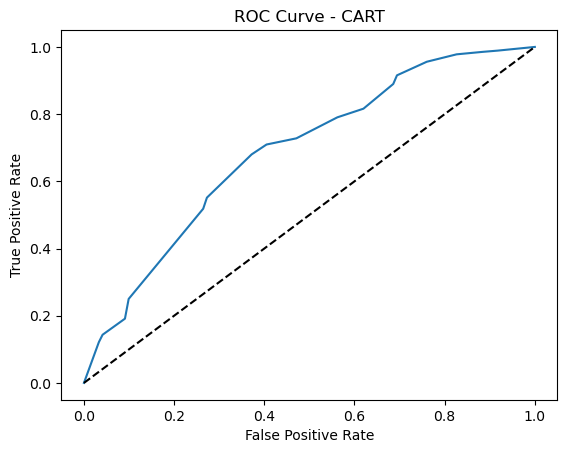

In [32]:
from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_decisiontree.predict_proba(tvShows_test_X)[:,1]
y_pred = best_decisiontree.predict(tvShows_test_X)

print("Accuracy: ", accuracy_score(tvShows_test_Y, y_pred))
print("AUC: ", roc_auc_score(tvShows_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(tvShows_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CART')
plt.show()

AUCPR:  0.8208607937734644


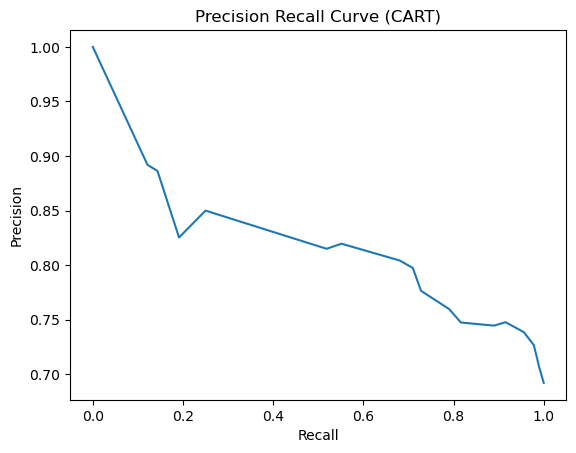

F1 Score:  0.8107202680067002


In [33]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(tvShows_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve (CART)')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(tvShows_test_Y, y_pred))

### Model 2 : Random Forest

In [26]:
gsRF.fit(tvShows_train_X, tvShows_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
                                                                        ('bagofw',
                                                                         CountVectorizer(),
                                                                         'genres')])),
                                       ('randomforest',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforest__criterion': ['gini', 'entropy',
                                                     'log_loss'],
                         'randomforest__max_depth': [5, 10, 15, 20, 25, 30],
                         'randomforest__min_samples_leaf': [1, 5, 10, 15, 20],
                         'randomforest__n_estimators': [100, 250, 500]},
             refit='AUC', scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'})

In [27]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gsRF.best_params_

# print gsRF.best_score_ to 5 decimal places
print("Validation AUC for Random Forest = {:.5f}".format(gsRF.best_score_))
best_RF = gsRF.best_estimator_

Validation AUC for Random Forest = 0.79436


Accuracy:  0.7608142493638677
AUC:  0.757413709285367
F1 Score:  0.8438538205980066


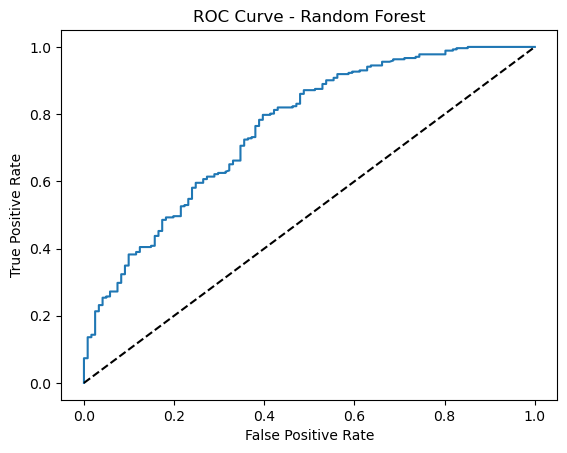

In [34]:
from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_RF.predict_proba(tvShows_test_X)[:,1]
y_pred = best_RF.predict(tvShows_test_X)

print("Accuracy: ", accuracy_score(tvShows_test_Y, y_pred))
print("AUC: ", roc_auc_score(tvShows_test_Y, y_prob_pred))

# print f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(tvShows_test_Y, y_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(tvShows_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.show()

AUCPR:  0.8647529377650764


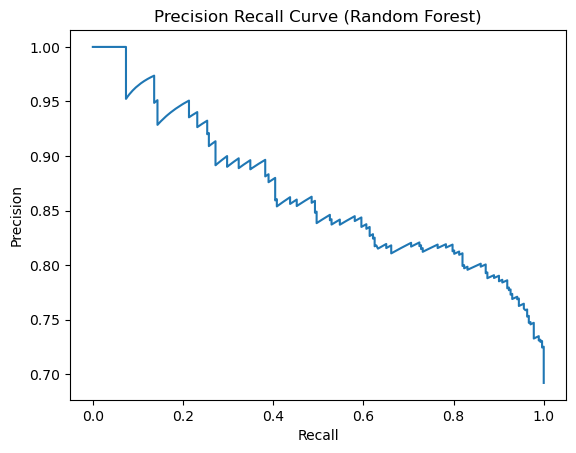

F1 Score:  0.8438538205980066


In [35]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(tvShows_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve (Random Forest)')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(tvShows_test_Y, y_pred))

### Model 3 : Neural Network

In [172]:
gsMLP.fit(tvShows_train_X, tvShows_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yenhann/o

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
            

In [173]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gsMLP.best_params_
gsMLP.best_score_
best_MLP = gsMLP.best_estimator_

Accuracy:  0.72264631043257
AUC:  0.7040896937287311


/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


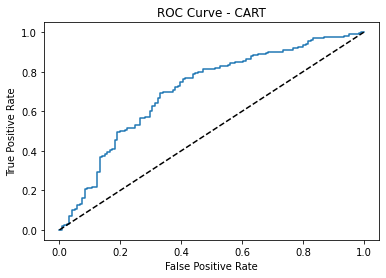

In [174]:
best_MLP.fit(tvShows_train_X, tvShows_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_MLP.predict_proba(tvShows_test_X)[:,1]
y_pred = best_MLP.predict(tvShows_test_X)

print("Accuracy: ", accuracy_score(tvShows_test_Y, y_pred))
print("AUC: ", roc_auc_score(tvShows_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(tvShows_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.show()

AUCPR:  0.8361852985711762


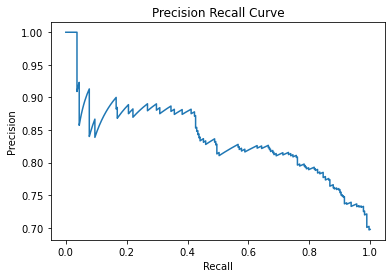

F1 Score:  0.8238897396630934


In [176]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(tvShows_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(tvShows_test_Y, y_pred))